In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

# stopwords
import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [11]:
# initialize the empty dataframe
df = pd.DataFrame(columns=['URL', 'Heading', 'SubHeadings', 'Content'])

In [12]:
def get_links_from_bbc_news():
    res = requests.get('https://www.bbc.com/news')

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        # Find the parent div with class 'nw-c-top-stories--international'
        top_stories_div = soup_data.find('div', class_='nw-c-top-stories--international')

        # Check if the 'nw-c-top-stories--international' div was found
        if top_stories_div:
            # Find all <a> tags within the 'top_stories_div' with a class containing 'gs-c-promo-heading'
            promo_headings = top_stories_div.find_all('a', class_=lambda x: x and 'gs-c-promo-heading' in x)

            # Extract the links from the promo_headings
            links = [heading['href'] for heading in promo_headings]

            # Return the links
            return links
        else:
            print("The 'nw-c-top-stories--international' div was not found on the page.")
    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [13]:
links = get_links_from_bbc_news()
len(links)

17

In [14]:
# drop duplicates
links = list(set(links))
links = [link for link in links if 'live' not in link]
links

['/news/world-middle-east-67321241',
 '/news/world-europe-67342367',
 '/news/world-middle-east-67339008',
 '/news/world-africa-67342714',
 '/news/business-67316150',
 '/news/world-europe-67346780',
 '/news/world-us-canada-67346904',
 '/news/world-us-canada-67336799',
 '/news/world-africa-67342882',
 '/news/world-europe-67343002',
 '/news/science-environment-67343374',
 '/news/world-europe-67343009']

In [15]:
# assign the links to the dataframe
df['URL'] = links
df.head()

,URL,Heading,SubHeadings,Content
0,/news/world-middle-east-67321241,NaN,NaN,NaN
1,/news/world-europe-67342367,NaN,NaN,NaN
2,/news/world-middle-east-67339008,NaN,NaN,NaN
3,/news/world-africa-67342714,NaN,NaN,NaN
4,/news/business-67316150,NaN,NaN,NaN


In [16]:
MAIN_URL = 'https://www.bbc.com'

In [27]:
def requestArticle(idx, url):
    url_to_fetch = MAIN_URL + url

    # Send an HTTP GET request to the specified URL
    res = requests.get(url_to_fetch)

    # Check if the request was successful
    if res.status_code == 200:

        # df.loc[idx, 'RequestDate'] = pd.Timestamp.now()

        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        meta = soup_data.find('meta', attrs={'property': 'article:section'})

        if meta:
            # print("Topic:", meta['content'])
            df.loc[idx, 'Topic'] = meta['content']

        # Find the <article> tag and get all elements inside it
        article = soup_data.find('article')

        if article:
            # Find all elements (tags) inside the <article> tag
            article_elements = article.find_all()
            
            # Extract the heading
            heading = article.find('h1').text
            # print("Heading")
            # print(heading)

            # Extract the subheadings
            # get headlines with data-component="subheadline-block"
            subheadings = article.find_all('div', attrs={'data-component': 'subheadline-block'})
            subheadings = [subheading for subheading in subheadings if 'You may also be interested in:' not in subheading.text]
            subheadings = [subheading.text for subheading in subheadings]
            subheadings = (', ').join(subheadings)
            # print("SubHeading")
            # print(subheadings)


            # Extract the content
            content = '\n'.join([element.text for element in article_elements if element.name == 'p'])
            # print("Content")
            # print(content)

            # Update the dataframe
            df.loc[idx, 'Heading'] = heading
            df.loc[idx, 'SubHeadings'] = subheadings
            df.loc[idx, 'Content'] = content

        else:
            print("No <article> tag found on the page.")

    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [28]:
# Loop through the links and request each article
for idx, link in enumerate(links):
    requestArticle(idx, link)

In [29]:
df

,URL,Heading,SubHeadings,Content,Topic,MergedText,RequestDate
0,/news/world-middle-east-67321241,Hamas leader refuses to acknowledge killing of...,"Hostage crisis, More on Israel-Gaza war",A senior Hamas leader has refused to acknowled...,Middle East,hamas leader refuses acknowledge killing civil...,2023-11-07 19:17:21.071368
1,/news/world-europe-67342367,Ukraine war: Grenade birthday gift kills army ...,,A grenade given as a birthday present has blow...,Europe,ukraine war grenade birthday gift kills army c...,2023-11-07 19:17:21.170864
2,/news/world-middle-east-67339008,Israel's pain still raw a month after Hamas at...,More on Israel-Gaza war,It was a day that shattered Israel's sense of ...,Middle East,israel pain still raw month hamas attacks war ...,2023-11-07 19:17:21.275572
3,/news/world-africa-67342714,Mr Ibu: Nigerian Nollywood actor's leg amputat...,,Family members of popular Nigerian comic actor...,Africa,mr ibu nigerian nollywood actor leg amputated ...,2023-11-07 19:17:21.373471
4,/news/business-67316150,WeWork forced to file for bankruptcy in the US,,"WeWork, the shared office firm that was once v...",Business,wework forced file bankruptcy us wework shared...,2023-11-07 19:17:21.479428
5,/news/world-europe-67346780,Portuguese PM AntÃ³nio Costa resigns over lith...,,Portuguese Prime Minister AntÃ³nio Costa resig...,Europe,portuguese pm antã³nio costa resigns lithium d...,2023-11-07 19:17:21.577156
6,/news/world-us-canada-67346904,Tennis great Serena Williams named 'fashion icon',,Tennis legend Serena Williams has been named a...,US & Canada,tennis great serena williams named icon tennis...,2023-11-07 19:17:21.677922
7,/news/world-us-canada-67336799,Canadian poet Rupi Kaur declines White House v...,More on Israel-Gaza war,Canadian poet Rupi Kaur has declined an invita...,US & Canada,canadian poet rupi kaur declines white house v...,2023-11-07 19:17:21.781407
8,/news/world-africa-67342882,South Africa crime: Thieves put gun to Transpo...,,South Africa's transport minister has describe...,Africa,south africa crime thieves put gun transport m...,2023-11-07 19:17:21.894795
9,/news/world-europe-67343002,Germany agrees to consider UK-style plan on pr...,,"German Chancellor Olaf Scholz has pledged to ""...",Europe,germany agrees consider plan processing asylum...,2023-11-07 19:17:21.997777


In [30]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens] # everything lowercase
    tokens = [word.strip() for word in tokens] # strips whitespaces
    tokens = [word for word in tokens if word.isalnum()] # only alpha numerical values
    tokens = [word for word in tokens if not word in stop_words] # removes stopwords
    return tokens 

In [31]:
for idx, row in df.iterrows():
    df.loc[idx, 'Heading'] = cleanText(row['Heading'])
    df.loc[idx, 'SubHeadings'] = cleanText(row['SubHeadings'])
    df.loc[idx, 'Content'] = cleanText(row['Content'])

ValueError: Must have equal len keys and value when setting with an iterable

In [22]:
df

,URL,Heading,SubHeadings,Content,Topic
0,/news/world-middle-east-67321241,"[hamas, leader, refuses, acknowledge, killing,...","[hostage, crisis, war]","[senior, hamas, leader, refused, acknowledge, ...",Middle East
1,/news/world-europe-67342367,"[ukraine, war, grenade, birthday, gift, kills,...",[],"[grenade, given, birthday, present, blown, kil...",Europe
2,/news/world-middle-east-67339008,"[israel, pain, still, raw, month, hamas, attacks]",[war],"[day, shattered, israel, sense, invincibility,...",Middle East
3,/news/world-africa-67342714,"[mr, ibu, nigerian, nollywood, actor, leg, amp...",[],"[family, members, popular, nigerian, comic, ac...",Africa
4,/news/business-67316150,"[wework, forced, file, bankruptcy, us]",[],"[wework, shared, office, firm, valued, 47bn, f...",Business
5,/news/world-europe-67346780,"[portuguese, pm, antã³nio, costa, resigns, lit...",[],"[portuguese, prime, minister, antã³nio, costa,...",Europe
6,/news/world-us-canada-67346904,"[tennis, great, serena, williams, named, icon]",[],"[tennis, legend, serena, williams, named, fash...",US & Canada
7,/news/world-us-canada-67336799,"[canadian, poet, rupi, kaur, declines, white, ...",[war],"[canadian, poet, rupi, kaur, declined, invitat...",US & Canada
8,/news/world-africa-67342882,"[south, africa, crime, thieves, put, gun, tran...",[],"[south, africa, transport, minister, described...",Africa
9,/news/world-europe-67343002,"[germany, agrees, consider, plan, processing, ...",[],"[german, chancellor, olaf, scholz, pledged, ex...",Europe


In [23]:
# join all the tokens into a single string
df['MergedText'] = df['Heading'] + df['SubHeadings'] + df['Content']
df['MergedText'] = df['MergedText'].apply(lambda x: ' '.join(x))

df.head()

,URL,Heading,SubHeadings,Content,Topic,MergedText
0,/news/world-middle-east-67321241,"[hamas, leader, refuses, acknowledge, killing,...","[hostage, crisis, war]","[senior, hamas, leader, refused, acknowledge, ...",Middle East,hamas leader refuses acknowledge killing civil...
1,/news/world-europe-67342367,"[ukraine, war, grenade, birthday, gift, kills,...",[],"[grenade, given, birthday, present, blown, kil...",Europe,ukraine war grenade birthday gift kills army c...
2,/news/world-middle-east-67339008,"[israel, pain, still, raw, month, hamas, attacks]",[war],"[day, shattered, israel, sense, invincibility,...",Middle East,israel pain still raw month hamas attacks war ...
3,/news/world-africa-67342714,"[mr, ibu, nigerian, nollywood, actor, leg, amp...",[],"[family, members, popular, nigerian, comic, ac...",Africa,mr ibu nigerian nollywood actor leg amputated ...
4,/news/business-67316150,"[wework, forced, file, bankruptcy, us]",[],"[wework, shared, office, firm, valued, 47bn, f...",Business,wework forced file bankruptcy us wework shared...


In [24]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [25]:
tfidf, vectorizer = TfIdfvectorGenerator(df['MergedText']) 

documents processed: 12
time spent: 0:00:00.009984


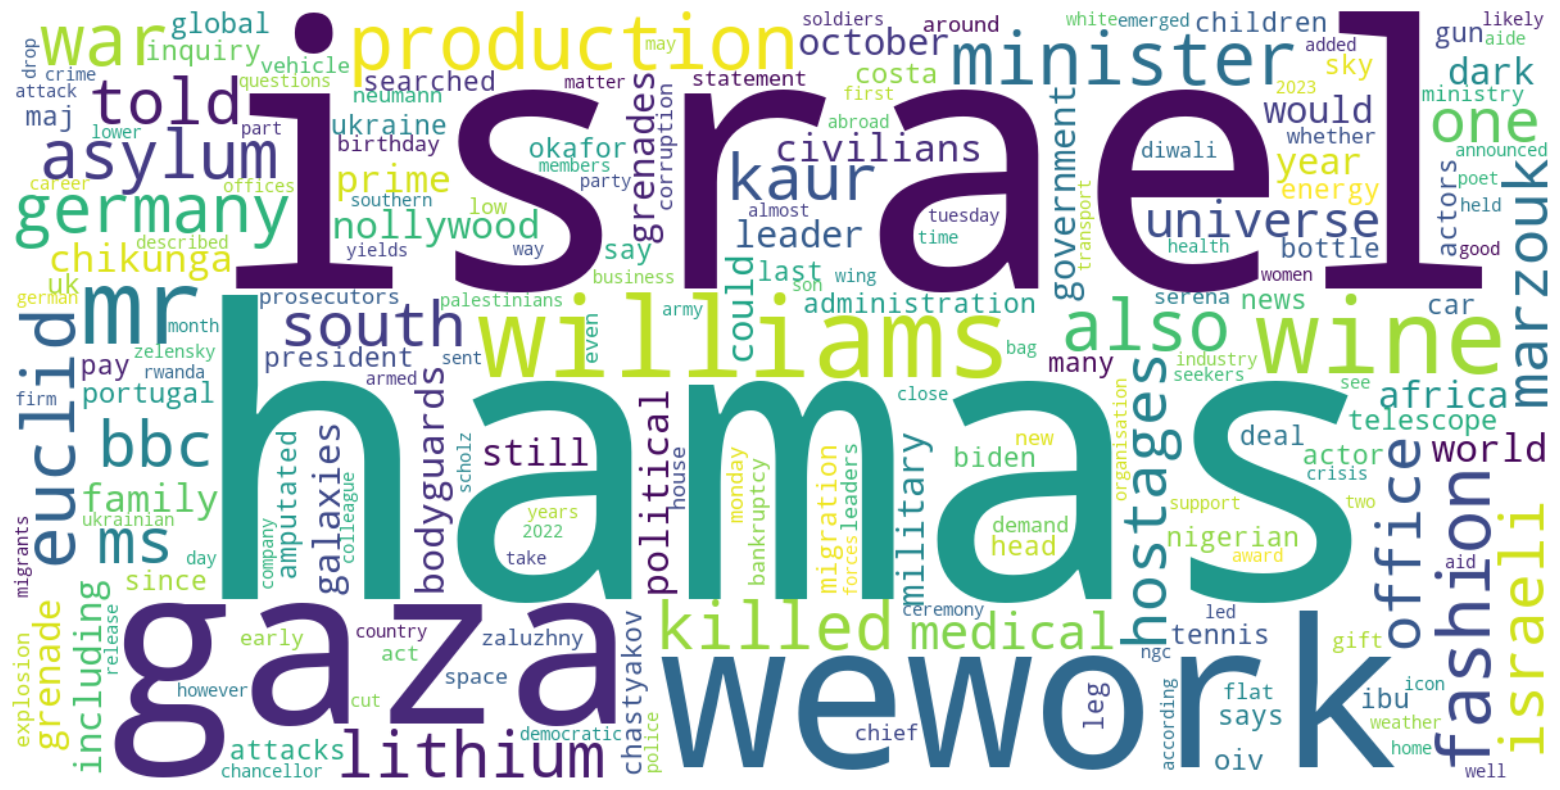

In [26]:
# Step 2: Rank words by TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word
tfidf_scores = tfidf.sum(axis=0).A1

# Create a dictionary of words and their TF-IDF scores
word_scores = dict(zip(feature_names, tfidf_scores))

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()